#### The Besag-York-Mollie Model for Spatial Data

In [5]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt

from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

In [9]:
# these libraries are not dependencies of pymc

import networkx as nx
import nutpie

In [10]:
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Demonstrating the BYM model on the New York City pedestrian accidents datase

In [11]:
try:
    df_edges = pd.read_csv(os.path.join("..", "data", "nyc_edgelist.csv"))
except FileNotFoundError:
    df_edges = pd.read_csv(pm.get_data("nyc_edgelist.csv"))

In [12]:
df_edges

,N,N_edges,node1,node2
0,1921,5461,1,1452
1,1921,5461,1,1721
2,1921,5461,2,3
3,1921,5461,2,4
4,1921,5461,2,5
...,...,...,...,...
5456,1921,5461,1918,1919
5457,1921,5461,1918,1921
5458,1921,5461,1919,1920
5459,1921,5461,1919,1921


To actually get our model running, however, we’ll need to convert the edgelist to an adjacency matrix. The code below performs that task along with some other clean up tasks.

In [13]:
# convert edgelist to adjacency matrix

# extract and reformat the edgelist

nodes = np.stack((df_edges.node1.values, df_edges.node2.values))
nodes = nodes.T

In [14]:
# subtract one for python indexing

nodes = nodes - 1

In [15]:
# convert the number of nodes to a integer

N = int(df_edges.N.values[0])

In [16]:
# build a matrix of zeros to store adjacency
# it has size NxN where N is the number of
# areas in the dataset

adj = np.zeros((N, N))

In [17]:
# loop through the edgelist and assign 1
# to the location in the adjacency matrix
# to represent the edge
# this will only fill in the upper triangle
# of the matrix

for node in nodes:
    adj[tuple(node)] = 1

# add the transpose to make the adjacency
# matrix symmetrical

In [18]:
W_nyc = adj.T + adj

In [20]:
W_nyc.shape

(1921, 1921)

We’ll compute the scaling factor.

In [21]:
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [22]:
scaling_factor = scaling_factor_sp(W_nyc)
scaling_factor

0.7136574058611265

we’ll also explore one predictor variable, the social fragmentation index. 

In [23]:
try:
    df_nyc = pd.read_csv(os.path.join("..", "data", "nyc_traffic.csv"))
except FileNotFoundError:
    df_nyc = pd.read_csv(pm.get_data("nyc_traffic.csv"))

In [24]:
y = df_nyc.events_2001.values
E = df_nyc.pop_2001.values
fragment_index = df_nyc.fragment_index.values

In [37]:
y

array([0., 1., 0., ..., 0., 2., 1.])

In [31]:
# Most census tracts have huge populations
# but a handful have 0. We round
# those up to 10 to avoid triggering an error
# with the log of 0.

E[E < 10] = 10
log_E = np.log(E)
area_idx = df_nyc["census_tract"].values
coords = {"area_idx": area_idx}

In [34]:
area_idx

array([36005000100, 36005000200, 36005000400, ..., 36085031901,
       36085031902, 36085032300])

In [35]:
coords

{'area_idx': array([36005000100, 36005000200, 36005000400, ..., 36085031901,
        36085031902, 36085032300])}

We can get a sense of the spatial structure by visualizing the adjacency matrix. The figure below only captures the relative position of the census tracks. It doesn’t bother with the absolute position so it doesn’t look like New York City. This representation highlights how the city is composed of several regions of uniformly connected areas, a few central hubs that have a huge number of connections, and then a few narrow corridors.

In [32]:
# build the positions of the nodes. We'll only
# generate the positions once so that we can
# compare visualizations from the data to
# the model predictions.
# I found that running spectral layout first
# and passing it to spring layout makes easy to read
# visualizations for large datasets.

G_nyc = nx.Graph(W_nyc)
pos = nx.spectral_layout(G_nyc)
pos = nx.spring_layout(G_nyc, pos=pos, seed=RANDOM_SEED)

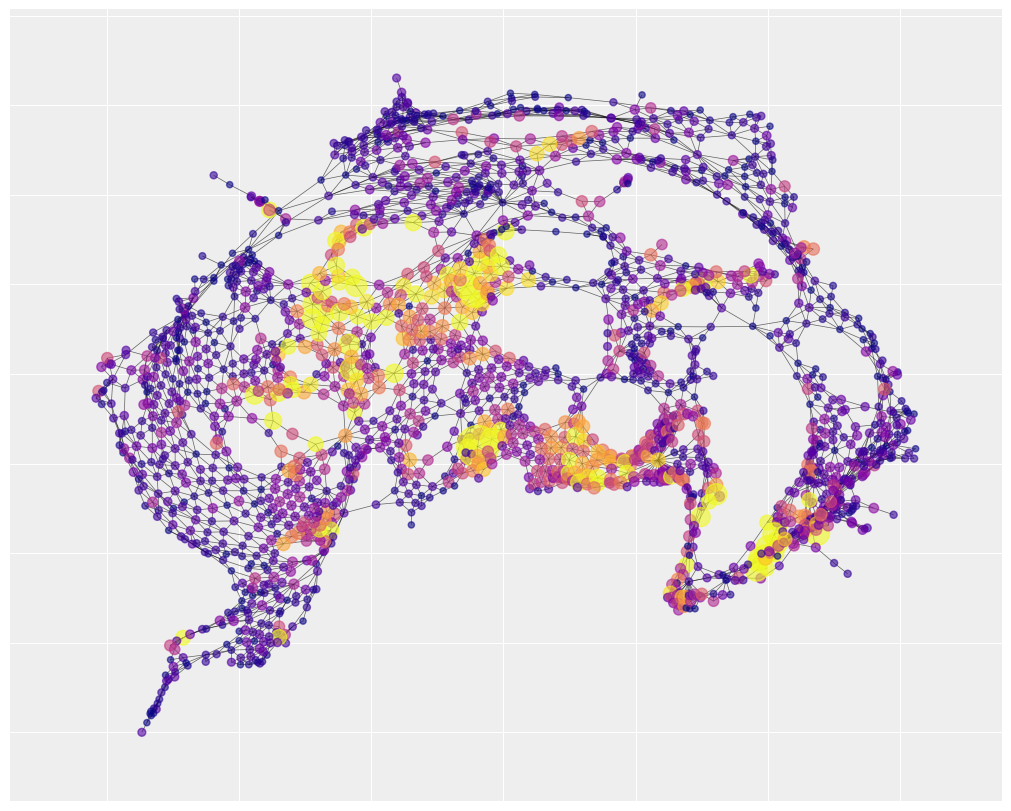

In [33]:
# the spread of the data is pretty high. Most areas have 0 accidents.
# one area has 300. Color-gradient based visualization doesn't work
# well under those conditions. So for the purpose of the color
# we'll cap the accidents at 30 using vmax
#
# however, we'll also make the node size sensitive to the real
# number of accidents. So big yellow nodes have way more accidents
# than small yellow nodes.

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y,
)

We can also visualize the spatial layout of social fragmentation.

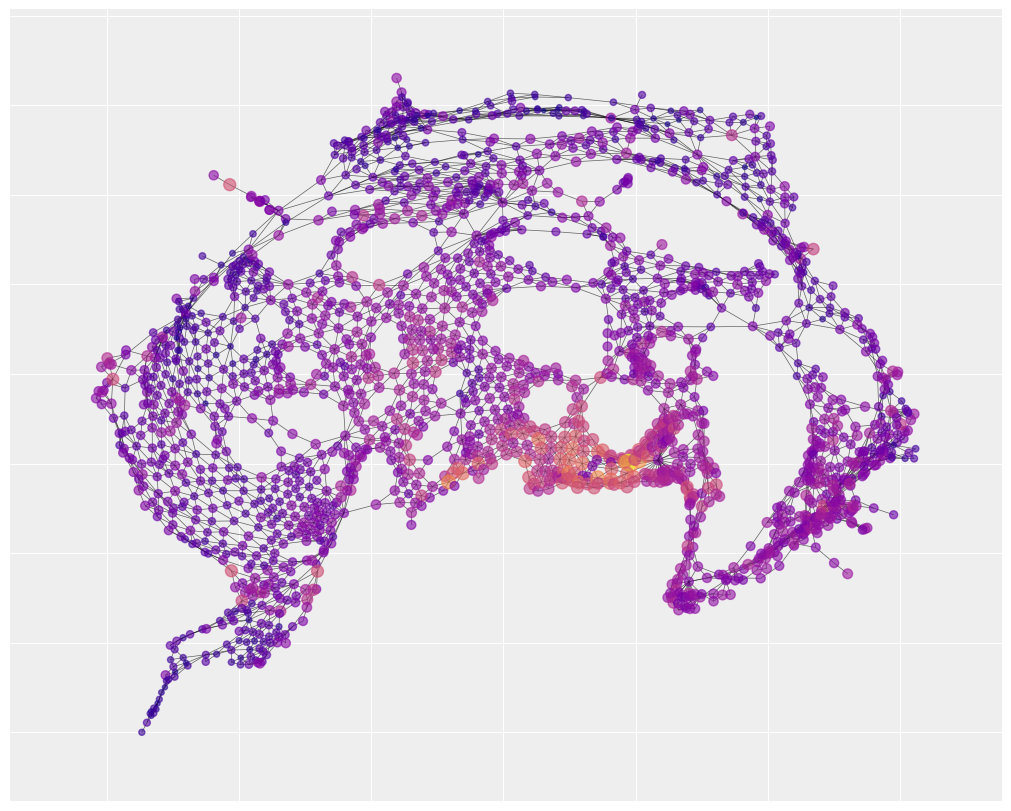

In [38]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=fragment_index,
    cmap="plasma",
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=40 + 5 * fragment_index,
)

Specifying a BYM model with PyMC

In [39]:
with pm.Model(coords=coords) as BYM_model:
    # intercept
    beta0 = pm.Normal("beta0", 0, 1)

    # fragmentation effect
    beta1 = pm.Normal("beta1", 0, 1)

    # independent random effect
    theta = pm.Normal("theta", 0, 1, dims="area_idx")

    # spatially structured random effect
    phi = pm.ICAR("phi", W=W_nyc, dims="area_idx")

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)

    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pm.Deterministic(
        "mixture", pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi, dims="area_idx"
    )

    # exponential link function to ensure
    # predictions are positive
    mu = pm.Deterministic(
        "mu", pt.exp(log_E + beta0 + beta1 * fragment_index + sigma * mixture), dims="area_idx"
    )

    y_i = pm.Poisson("y_i", mu, observed=y)

Sampling the model

In [40]:
# if you haven't installed nutpie, it's okay to to just delete
# 'nuts_sampler="nutpie"'. The default sampler took roughly 12 minutes on
# my machine.

with BYM_model:
    idata = pm.sample(1000, nuts_sampler="nutpie", random_seed=rng)

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/pymc/pytensorf.py:1066: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.13,127
,2000,0,0.13,63
,2000,0,0.13,63
,2000,0,0.13,63


We can evaluate the sampler in several ways. First, it looks like all our chains converged. All parameters have rhat values very close to one.



In [41]:
rhat = az.summary(idata, kind="diagnostics").r_hat.values
sum(rhat > 1.03)

0

Second, the trace plots on all the main parameters look stationary and well-mixed. They also reveal that the mean of rho is somewhere around 0.50, indicating that spatial effects are likely present in the data.


/tmp/ipykernel_1561523/1864615084.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


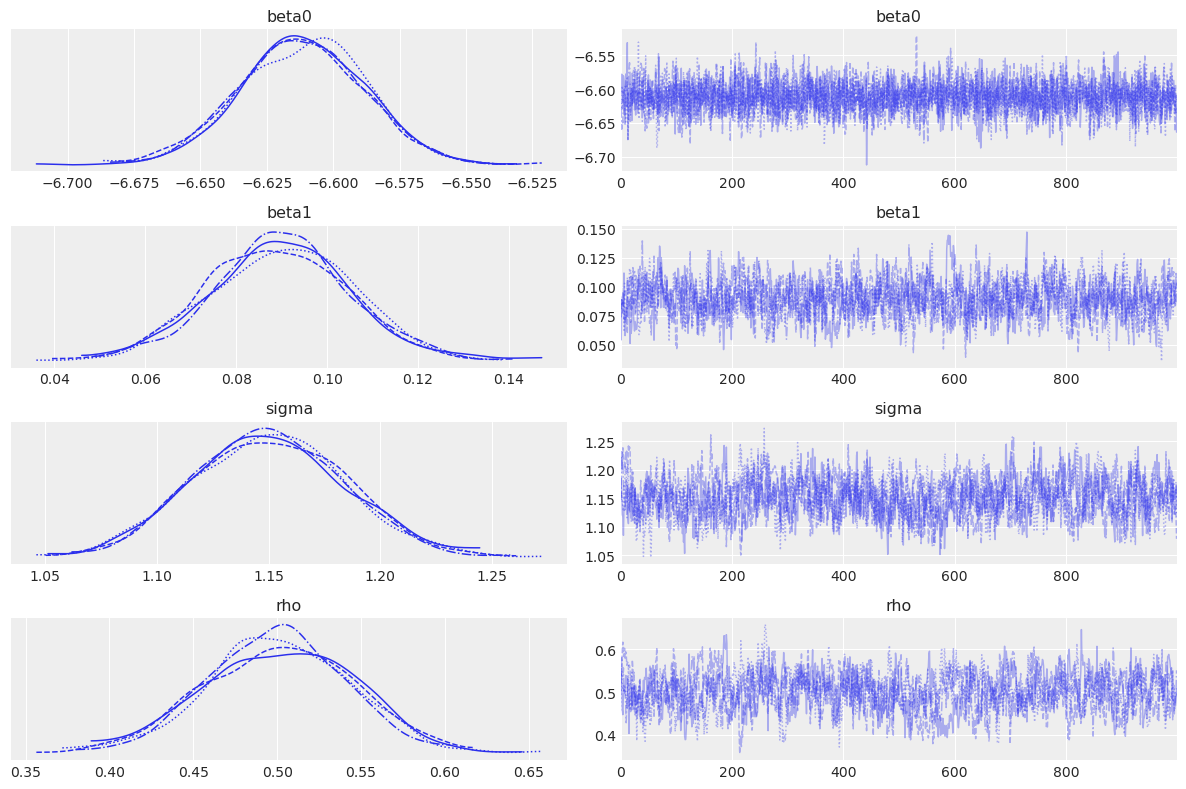

In [42]:
az.plot_trace(idata, var_names=["beta0", "beta1", "sigma", "rho"])
plt.tight_layout();

Posterior predictive checking

In the first case, we’ll visualize only the predictions that come from the spatial component of the model. In other words, we are assuming e =0 and we ignore theta and social fragmentation. Then we’ll overlay our predictions onto the same adjacency map we built earlier.



Sampling: []


/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

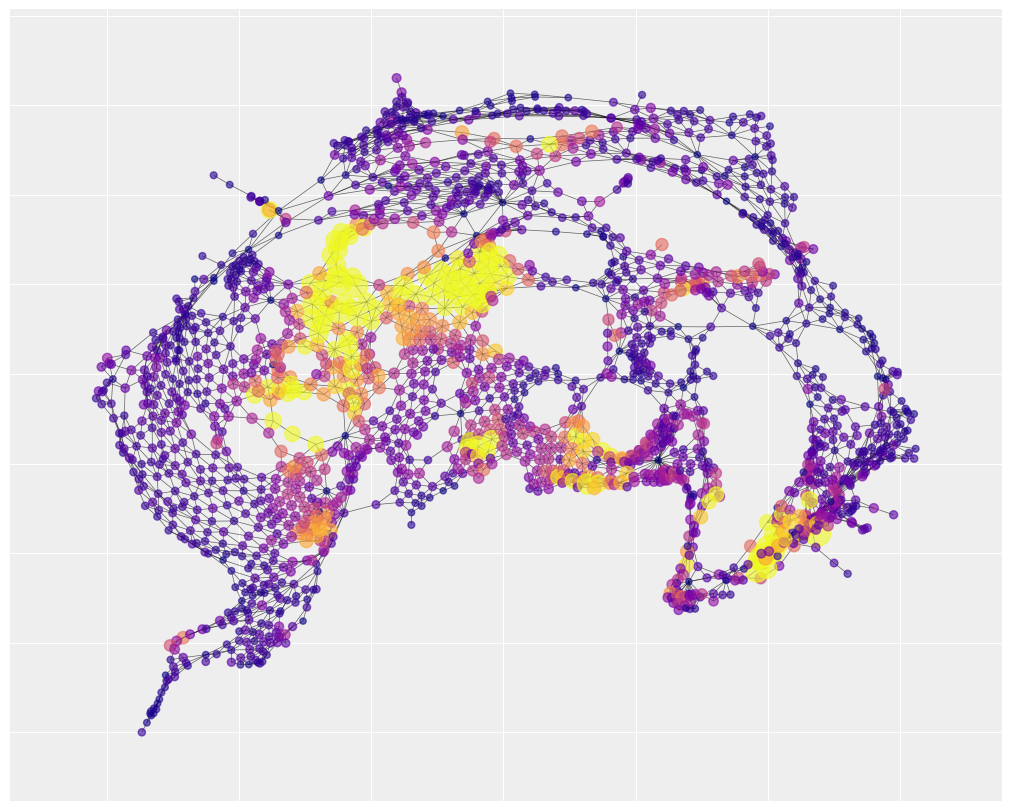

In [43]:
# draw posterio

with pm.do(BYM_model, {"rho": 1.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_spatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_spatial_pred,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_spatial_pred,
)

The resulting picture is called spatial smoothing. Nearby areas tend to be very similar to each other, resulting in distinct neighborhoods of risk. In the dark purple regions, there is little variance and the number of predicted accidents is low, close to zero.

Finally, we might look at the unstructured variance by assuming e=0. If our model managed to partition variance successfully, there should not be too many spatial clusters left over in the unstructured variance. Instead, variance should be scattered all over the map.

Sampling: []


/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

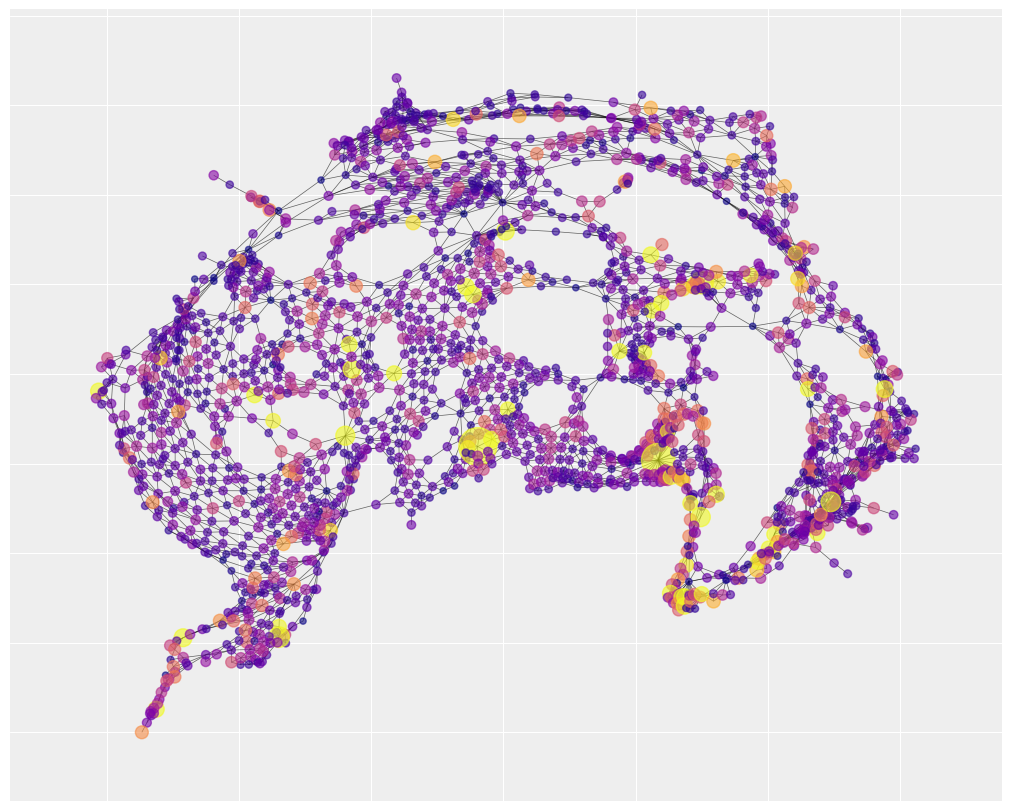

In [44]:
with pm.do(BYM_model, {"rho": 0.0, "beta1": 0}):
    y_predict = pm.sample_posterior_predictive(
        idata, var_names=["mu", "mixture"], predictions=True, extend_inferencedata=False
    )

y_unspatial_pred = y_predict.predictions.mu.mean(dim=["chain", "draw"]).values

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G_nyc,
    pos=pos,
    node_color=y_unspatial_pred,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_unspatial_pred,
)